In [67]:
import torch
import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data

In [68]:
# def prelucrare_date():
#     csv = pd.read_csv('./stroke_risk_dataset.csv', encoding='utf-8')
#     gender = ['Male','Female']
#     dict_gender = {t: i + 1 for i, t in enumerate(gender)}
#     csv['gender'] = csv['gender'].map(dict_gender).fillna(-1).astype(int)
#     #impartim datle pentru linear regression si logistic regression in date de train si test
#     li_r_labels = torch.tensor(csv["stroke_risk_percentage"].values).float().unsqueeze(1)
#     lo_r_labels = torch.tensor(csv["at_risk"].values).float().unsqueeze(1)
#     # print(li_r_labels)
#     # print(lo_r_labels)
#     li_r_data = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
#     lo_r_data = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
#     # print(li_r_data)
#     # print(lo_r_data)
#     li_r_data = torch.tensor(li_r_data.values).float()
#     lo_r_data = torch.tensor(lo_r_data.values).float()
#     li_r_data, li_r_labels = shuffle(li_r_data, li_r_labels, random_state=0)
#     lo_r_data, lo_r_labels = shuffle(lo_r_data, lo_r_labels, random_state=0)
#     li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels = train_test_split(
#         li_r_data, li_r_labels, test_size=0.3, random_state=0)
#     lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels = train_test_split(
#         lo_r_data, lo_r_labels, test_size=0.3, random_state=0)
#     return li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels,lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels

In [69]:
# li_r_train_data, li_r_test_data, li_r_train_labels, li_r_test_labels,lo_r_train_data, lo_r_test_data, lo_r_train_labels, lo_r_test_labels=prelucrare_date()
# torch.save({
#     'train_data': li_r_train_data,
#     'test_data': li_r_test_data,
#     'train_labels': li_r_train_labels,
#     'test_labels': li_r_test_labels
# }, 'date_liniar_regression.pth')
# torch.save({
#     'train_data': lo_r_train_data,
#     'test_data': lo_r_test_data,
#     'train_labels': lo_r_train_labels,
#     'test_labels': lo_r_test_labels
# }, 'date_logistic_regression.pth')

In [70]:
def incarcare_date(path):
    date_salvate = torch.load(path,weights_only=True)
    x_train = date_salvate['train_data']
    x_test = date_salvate['test_data']
    y_train = date_salvate['train_labels']
    y_test = date_salvate['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [71]:
def normalizare_date(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [72]:
x_train,x_test,y_train,y_test = incarcare_date('date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalizare_date(x_train,x_test,y_train,y_test)
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul, deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 17])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 17])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 17])
torch.Size([10500, 17])


In [73]:
class LinearRegression(torch.nn.Module):
    def __init__(self, n_features, learning_rate=1e-2, momentum=0.5, epochs=15):
        super(LinearRegression, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        self.epochs = epochs
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        self.criterion = torch.nn.MSELoss()
    def forward(self, x):
        pred = self.lr(x)
        return pred
    def forward_on_encrypted_data(self,enc_x):
        enc_pred = enc_x.dot(self.lr.weight.data.tolist()[0])+self.lr.bias.data.tolist()
        return enc_pred

    def fit(self, x_train, y_train):
        loss_values = []
        for e in range(1, self.epochs + 1):
            self.optimizer.zero_grad()
            pred = self.forward(x_train)
            loss = self.criterion(pred, y_train)
            loss.backward()
            self.optimizer.step()
            loss_values.append(loss.item())
            print(f"Loss at epoch {e}: {loss.item()}")
        sns.set_theme(style="darkgrid", palette="pastel")
        plt.figure(figsize=(8, 5))
        sns.lineplot(x=range(1, self.epochs + 1), y=loss_values, marker='o', linewidth=2.5, color="darkred")
        plt.xlabel('Epoci', fontsize=12)
        plt.ylabel('Pierdere', fontsize=12)
        plt.title('Evoluția pierderii în timpul antrenării pe setul de date necriptat', fontsize=14)
        plt.savefig('li_r_loss_curve_training_on_clear_data.png')
        plt.show()


In [74]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

Loss at epoch 1: 1.18039870262146
Loss at epoch 2: 1.1064914464950562
Loss at epoch 3: 1.0031988620758057
Loss at epoch 4: 0.8941723704338074
Loss at epoch 5: 0.7905903458595276
Loss at epoch 6: 0.6969594359397888
Loss at epoch 7: 0.6144652962684631
Loss at epoch 8: 0.5427566170692444
Loss at epoch 9: 0.4808517396450043
Loss at epoch 10: 0.42757871747016907
Loss at epoch 11: 0.38177797198295593
Loss at epoch 12: 0.3423875868320465
Loss at epoch 13: 0.3084707260131836
Loss at epoch 14: 0.2792174220085144
Loss at epoch 15: 0.2539350092411041


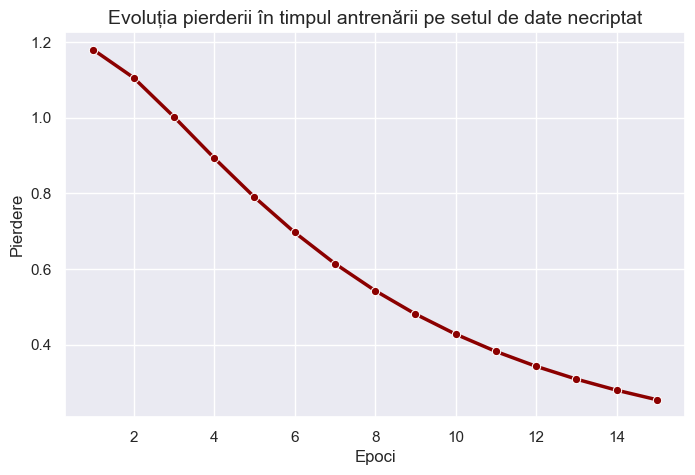

Antrenarea modelului pe date necriptate a durat:0.44929630000001452572 secunde


In [75]:

#antrenare pe date clare
li_r_model = LinearRegression(n_features=x_train.shape[1])

t_start = time.perf_counter()
li_r_model.fit(x_train[:1000], y_train[:1000])
t_end = time.perf_counter()
print(f"Antrenarea modelului pe date necriptate a durat:{(t_end - t_start):.20f} secunde")

save_model(li_r_model,'li_r_trained_on_clear_data.pkl')



In [76]:
def metrici_date_test_clare(model, x, y):
    t_start = time.perf_counter()
    pred = model.forward(x)
    t_end = time.perf_counter()
    print(f"predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    print(f"Predictions: {pred.shape}")
    print(f"Actual values: {y.shape}")
    y = y.detach().numpy()
    pred = pred.detach().numpy()
    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Valori Reale vs. Predicții', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("./li_r_trained_on_clear_data_predictions_on_clear_data.png")
    plt.show()
    return r2,mse

predictiile pe testul de date necriptate au durat:0.00015620000002058987 secunde
Predictions: torch.Size([700, 1])
Actual values: torch.Size([700, 1])
R^2 Score = 0.8049
MSE = 0.2016


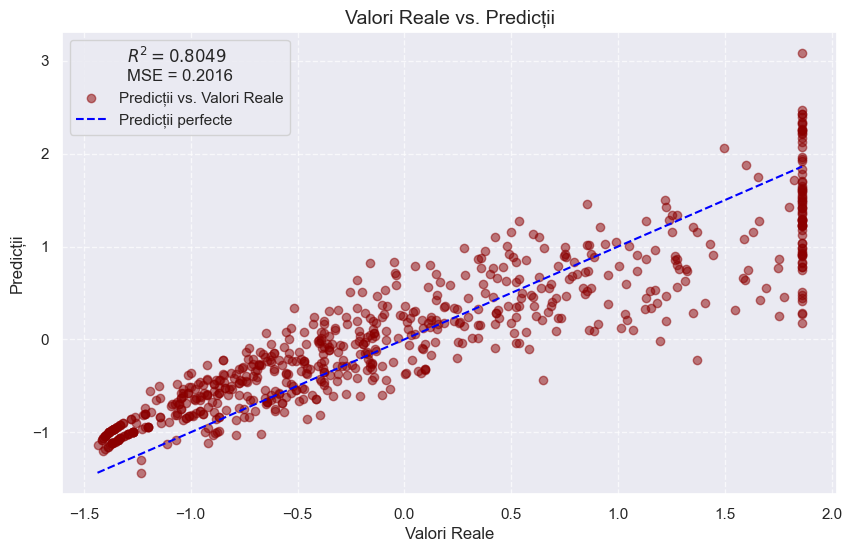

In [77]:
r2_clear_data, mse_clear_data=metrici_date_test_clare(li_r_model,x_test[:700],y_test[:700])

In [78]:
def importanta_caracteristicilor(model, feature_names):
    weights = model.lr.weight.detach().numpy().flatten()

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = np.array(feature_names)[sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_clear_data_feature_importance.png")
    plt.show()



17


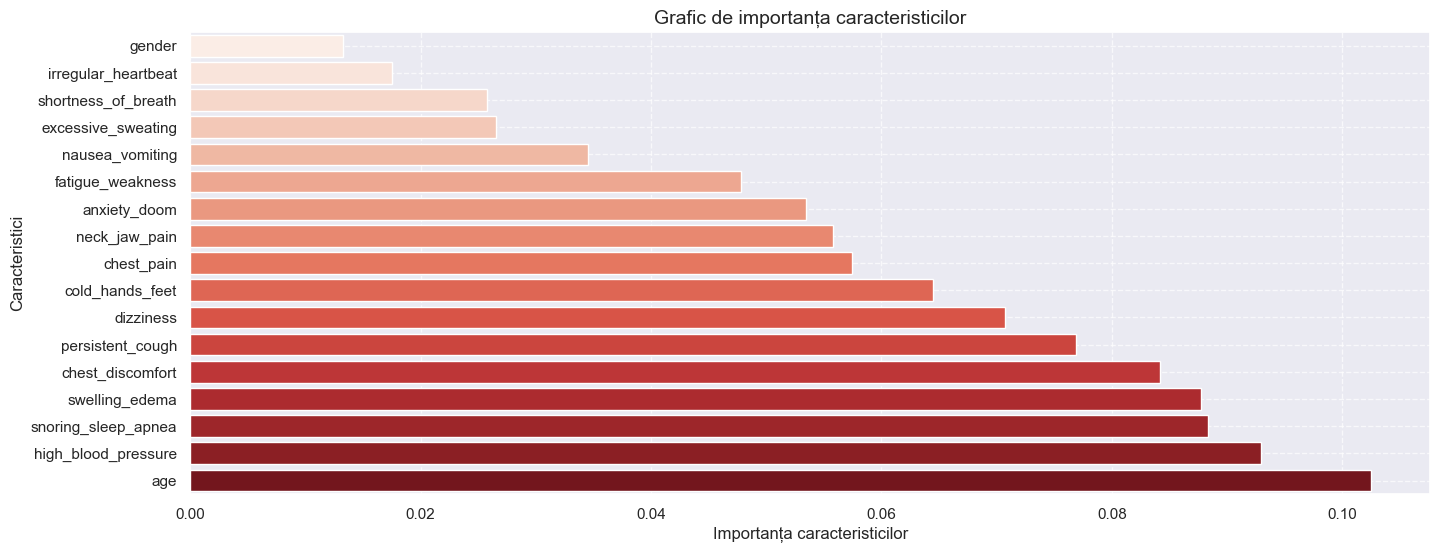

In [79]:
csv = pd.read_csv('./stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk"])
header = csv.columns.tolist()
print(len(header))
importanta_caracteristicilor(li_r_model,header) 

preziceri pe date criptate

In [80]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [81]:
def criptatea_datelor(ctx_eval):
    t_start = time.perf_counter()
    enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test[:700]]
    t_end = time.perf_counter()
    print(f"Criptarea pe setul de date de test a durat {(t_end - t_start):.20f} secunde")
    
    return enc_x_test


In [82]:
def metrici_date_test_criptate(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in enc_x:
        pred = model.forward_on_encrypted_data(e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")

    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = enc_pred.decrypt()
        list_pred.append(decript)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")

    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Valori Reale vs. Predictii', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_clear_data_predictions_on_encrypted_data.png")
    plt.show()
  
    

Criptarea pe setul de date de test a durat 1.26742439999998168787 secunde
Predictiile pe testul de date criptat au durat:1.65985179999998422318 secunde
Decriptarea predictiilor a durat:0.09270609999998669082 secunde
R^2 Score = 0.7647
MSE = 0.2432


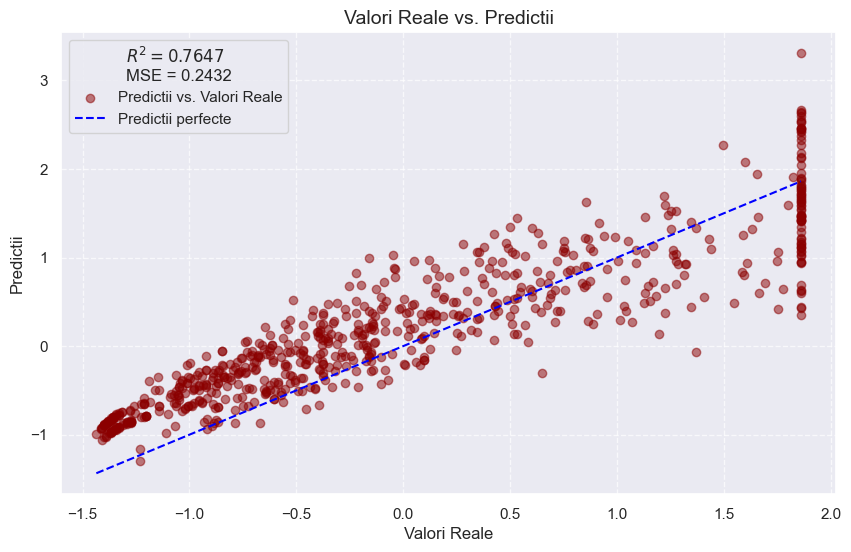

In [83]:
enc_x_test = criptatea_datelor(ctx_eval)
metrici_date_test_criptate(li_r_model,enc_x_test,y_test[:700])

se vede ca diferenta de precizie este destul de mica intre un prezicerile pe date clare si cele pe date criptate

in continuare vom vedea cum criptarea poate sa influenteze precizia si intre ce valori se situeaza de fapt precizia pe datele de test 


In [84]:
def interval_de_precizie(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    for e_x in enc_x:
        pred = model.forward_on_encrypted_data(e_x)
        enc_list_pred.append(pred)
    
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    for enc_pred in enc_list_pred:
        decript = enc_pred.decrypt()
        list_pred.append(decript)
    
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")
    return r2, mse

Criptarea pe setul de date de test a durat 1.20057110000016109552 secunde
R^2 Score = 0.7647
MSE = 0.2432
Criptarea pe setul de date de test a durat 1.26540620000014314428 secunde
R^2 Score = 0.7648
MSE = 0.2431
Criptarea pe setul de date de test a durat 1.20735160000003816094 secunde
R^2 Score = 0.7653
MSE = 0.2426
Criptarea pe setul de date de test a durat 1.14977270000008502393 secunde
R^2 Score = 0.7646
MSE = 0.2433
Criptarea pe setul de date de test a durat 1.17574489999969955534 secunde
R^2 Score = 0.7650
MSE = 0.2429
Criptarea pe setul de date de test a durat 1.16534319999982471927 secunde
R^2 Score = 0.7652
MSE = 0.2427
Criptarea pe setul de date de test a durat 1.12661200000002281740 secunde
R^2 Score = 0.7659
MSE = 0.2420
Criptarea pe setul de date de test a durat 1.16056709999975282699 secunde
R^2 Score = 0.7657
MSE = 0.2421
Criptarea pe setul de date de test a durat 1.15685669999993478996 secunde
R^2 Score = 0.7655
MSE = 0.2423
Criptarea pe setul de date de test a durat 1.1

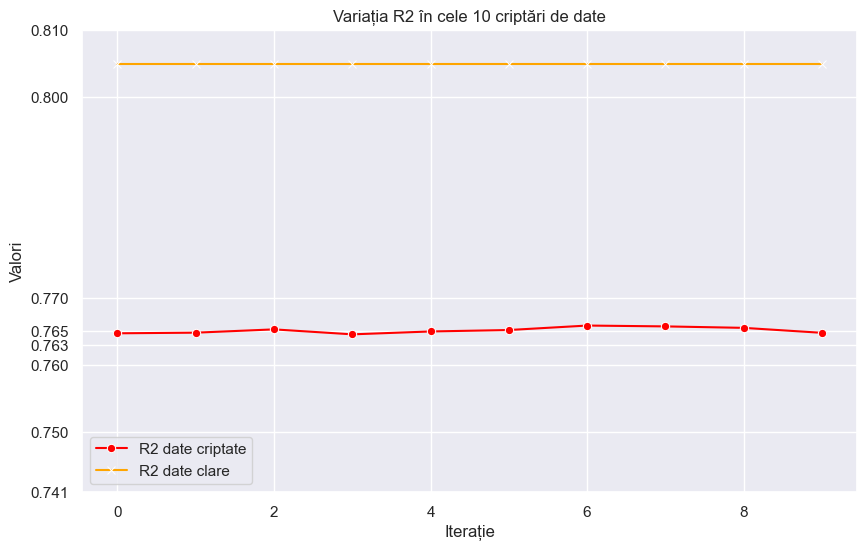

In [116]:
mse_list = []
r2_list = []
for incercari in range(10):
    enc_x_test = criptatea_datelor(ctx_eval)
    r2,mse = interval_de_precizie(li_r_model,enc_x_test,y_test[:700])
    mse_list.append(mse)
    r2_list.append(r2)


data = {
    'Iterație': [i for i in range(10)],
    'R2 Date Criptat': r2_list,
    'R2 Date clare': [r2_clear_data] * 10, 
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x='Iterație', y='R2 Date Criptat', label='R2 date criptate', marker='o', color='red')
sns.lineplot(data=df, x='Iterație', y='R2 Date clare', label='R2 date clare', marker='x', color='orange')


plt.title('Variația R2 în cele 10 criptări de date')
plt.xlabel('Iterație')
plt.ylabel('Valori')

y_ticks = [  0.741, 0.750, 0.760, 0.763, 0.765, 0.70, 0.77, 0.8,0.81]
plt.yticks(y_ticks)

plt.ylim(0.741, 0.81)  

plt.legend()

plt.savefig("li_r_trained_on_clear_data_variance_predictions_on_encrypted_data.png")

plt.show()
    